In [85]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

##### Import libary

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import kaos
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)
import kaos
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
# import utility
import importlib
import pandas as pd

pd.set_option('mode.chained_assignment', None)
from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
# import r_boxplot_utils
import r_plot_utils
import kaos
import fcgr


In [87]:
kmer_length =10
fasta_file_path = "../../../data/GCF_000017985.1_ASM1798v1_genomic.fna"

In [88]:
def strip_whitespace_from_string_columns(input_df):
    """
    Returns a copy of the DataFrame with leading and trailing whitespace removed
    from all string/object columns.
    
    Args:
        input_df (pd.DataFrame): Input DataFrame to process.
    
    Returns:
        pd.DataFrame: Copy with whitespace stripped from all string columns.
    """
    cleaned_df = input_df.copy()
    for column in cleaned_df.select_dtypes(include=['object', 'string']):
        cleaned_df[column] = cleaned_df[column].str.strip()
    return cleaned_df

In [89]:
# LTEE_mutational_data

In [90]:
mutational_data_all_population = pd.read_csv("../../../data/LTEE_mutational_data.csv")
mutational_data_all_population = strip_whitespace_from_string_columns(mutational_data_all_population)


In [91]:
class Oligo:
    @staticmethod
    def kgain(mutational_data: pd.DataFrame, fasta_file_path: str, fasta_string: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos

        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        '#CHROM': chrom_id,
                        'POS': genome_pos,
                        "REF": ref_allele,
                        "ALT": alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)

        # Final mutation-level summary (per-mutation, sum across all windows)
        mutation_kmer_gain_df = (
            df_kmer_windows
            .groupby(['#CHROM','POS', "REF", "ALT", 'ref_flank_seq', 'mutated_flank_seq'])["window_gain"]
            .sum()
            .reset_index()
            .rename(columns={"window_gain": "kGain"})
        )

        return mutation_kmer_gain_df
    

    @staticmethod
    def window_wise_kgain(mutational_data: pd.DataFrame, fasta_string: str, fasta_file_path: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and window wise kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos
        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        # fasta_string = kaos.read_fasta(fasta_file_path)
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        "chromosome_id": chrom_id,
                        'genome_position': genome_pos,
                        'reference_allele': ref_allele,
                        'alternate_allele': alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)


        return df_kmer_windows


In [92]:
allele_counts_by_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
allele_counts_by_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop=True)
allele_counts_by_generation.rename(columns={"CHROM": "#CHROM", "Position": "POS", "Ref_allele":"REF", "Alt_allele":"ALT", "label": "population_label"}, inplace=True)
allele_counts_by_generation['key'] = (
    allele_counts_by_generation['#CHROM'].astype(str) + '_' +
    allele_counts_by_generation['REF'] + '_' +
    allele_counts_by_generation['POS'].astype(str) + '_' +
    allele_counts_by_generation['ALT'] + '_' +
    allele_counts_by_generation['population_label'].astype(str)
)
allele_counts_by_generation =strip_whitespace_from_string_columns(allele_counts_by_generation)
allele_counts_by_generation.shape

(36922, 126)

In [93]:
allele_count_columns = [item for item in allele_counts_by_generation if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
allele_count_columns.extend(['#CHROM','POS', 'Gene', 'Allele', 'Annotation', 'REF', 'ALT','population_label', 'key']) ##Add other relavent information
allele_counts_by_generation = allele_counts_by_generation[allele_count_columns]
print(allele_counts_by_generation.shape)

(36922, 126)


In [94]:
nan_columns = allele_counts_by_generation.columns[allele_counts_by_generation.isna().any()]
df_with_nan = allele_counts_by_generation[nan_columns]
nan_counts = allele_counts_by_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


In [95]:
allele_counts_by_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop = True)
allele_counts_by_generation.shape

(36922, 118)

In [96]:
ac_columns = [item for item in allele_counts_by_generation.columns if item.startswith('AC:')]

In [97]:
# Make a working copy of the input DataFrame
allele_counts_per_generation = allele_counts_by_generation.copy()

# This DataFrame will store all per-mutation, per-generation, per-population records
long_format_mutation_counts = pd.DataFrame()

for generation_col in ac_columns:
    # Filter mutations where the allele count for this generation is nonzero
    nonzero_mutations = allele_counts_per_generation[allele_counts_per_generation[generation_col] != 0]

    # Select all relevant mutation and annotation information
    mutation_data = nonzero_mutations[['#CHROM', 'POS', 'Gene', 'REF', 'ALT', "population_label", "Annotation"]].copy()
    mutation_data['generation_label'] = generation_col
    mutation_data['allele_count'] = nonzero_mutations[generation_col]
    # If population_label is already included, this line is redundant, otherwise uncomment:
    # mutation_data['population_label'] = population

    # Append the records for this generation to the long-format DataFrame
    long_format_mutation_counts = pd.concat([long_format_mutation_counts, mutation_data], axis=0)

# Reset index after concatenation
long_format_mutation_counts.reset_index(inplace=True, drop=True)

# Extract the numeric generation (e.g., 'AC:1000' -> 1000)
long_format_mutation_counts['generation_number'] = (
    long_format_mutation_counts['generation_label'].str.extract(r'(\d+)').astype(int)
)
long_format_mutation_counts.drop("generation_label", axis=1, inplace=True)
long_format_mutation_counts.reset_index(inplace=True, drop=True)

long_format_mutation_counts['key'] = (
    long_format_mutation_counts['#CHROM'].astype(str) + '_' +
    long_format_mutation_counts['REF'] + '_' +
    long_format_mutation_counts['POS'].astype(str) + '_' +
    long_format_mutation_counts['ALT'] + '_' +
    long_format_mutation_counts['population_label'].astype(str) + '_' +
    long_format_mutation_counts['generation_number'].astype(str)
)



In [98]:
def mutate_fasta_by_generation(
    variant_data: pd.DataFrame,
    fasta_file_path: str,
    target_generation: int
) -> str:
    """
    Returns a mutated FASTA sequence for a specific generation, 
    substituting alternate alleles at given positions.

    Args:
        variant_data (pd.DataFrame): DataFrame with columns 
            ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number'].
        fasta_file_path (str): Path to the reference genome FASTA file.
        target_generation (int): The generation number to apply mutations for.

    Returns:
        str: Mutated DNA sequence as a string.

    Raises:
        ValueError: If required columns are missing.
    """
    import kaos

    required_cols = ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number']
    missing_cols = [col for col in required_cols if col not in variant_data.columns]
    if missing_cols:
        raise ValueError(
            f"Input DataFrame is missing required columns: {', '.join(missing_cols)}.\n"
            f"Columns found: {list(variant_data.columns)}"
        )

    variant_data = variant_data.copy()

    # Warn if duplicates are dropped
    before = variant_data.shape[0]
    variant_data = variant_data.drop_duplicates(subset=required_cols)
    after = variant_data.shape[0]
    if after < before:
        variant_data.drop_duplicates(inplace=True)
        variant_data.reset_index(inplace=True, drop=True)
        print(f"[Warning] Dropped {before - after} duplicate variant(s) based on columns {required_cols}.")

    # Read the reference sequence from FASTA
    reference_seq = kaos.read_fasta(fasta_file_path)

    # Filter mutations for the target generation
    relevant_variants = variant_data[variant_data["generation_number"] == target_generation]

    mutated_seq = list(reference_seq)
    for pos, alt_allele in zip(relevant_variants["POS"].astype(int), relevant_variants["ALT"]):
        seq_index = pos - 1  # 1-based to 0-based
        if 0 <= seq_index < len(mutated_seq):
            mutated_seq[seq_index] = alt_allele

    return ''.join(mutated_seq)


In [99]:
ref_fasta_string = kaos.read_fasta(fasta_file_path)

In [100]:
kgain_all_population_evolved = pd.DataFrame()

target_generation = 57500

dct_fasta_pop_wise_target_generation_57500 = dict()
for population in set(long_format_mutation_counts["population_label"]):

    individual_population_wise_mutation_counts, individual_population_wise_mutation_counts_for_selected_generation = [None] * 2

    individual_population_wise_mutation_counts = long_format_mutation_counts[long_format_mutation_counts["population_label"]==population]
    individual_population_wise_mutation_counts_for_selected_generation = individual_population_wise_mutation_counts[individual_population_wise_mutation_counts["generation_number"]==target_generation]
    individual_population_wise_mutation_counts_for_selected_generation.reset_index(inplace=True, drop=True)
    dct_fasta_pop_wise_target_generation_57500[population] = mutate_fasta_by_generation(variant_data = individual_population_wise_mutation_counts_for_selected_generation, fasta_file_path = fasta_file_path, target_generation=target_generation)
    

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = dct_fasta_pop_wise_target_generation_57500[population]
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_evolved = pd.concat([kgain_all_population_evolved, kgain_individual_population])
kgain_all_population_evolved.reset_index(inplace=True, drop=True)
kgain_all_population_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)


In [101]:
kgain_all_population_evolved['key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

In [102]:
kgain_all_population_evolved.shape

(36922, 9)

In [103]:
kgain_all_population_evolved.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key
0,NC_012967.1,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-1.937942,p6,NC_012967.1_A_63_C_p6
1,NC_012967.1,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,1.157555,p6,NC_012967.1_T_201_G_p6
2,NC_012967.1,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,0.616186,p6,NC_012967.1_A_322_G_p6
3,NC_012967.1,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,2.932760,p6,NC_012967.1_T_1173_G_p6
4,NC_012967.1,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.511868,p6,NC_012967.1_T_1624_C_p6


In [104]:
kgain_all_population_wt = pd.DataFrame()

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = kaos.read_fasta(fasta_file_path)
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_wt = pd.concat([kgain_all_population_wt, kgain_individual_population])

kgain_all_population_wt.reset_index(inplace=True, drop=True)
kgain_all_population_wt.rename(columns={"kGain": "wild_type_kGain"}, inplace=True)


In [105]:
kgain_all_population_wt.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label
0,NC_012967.1,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-10.385914,p6
1,NC_012967.1,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,-1.750693,p6
2,NC_012967.1,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,1.532477,p6
3,NC_012967.1,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,-1.685811,p6
4,NC_012967.1,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.939527,p6


In [106]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [107]:
def classify_mutator_type(pop_label):
    if pop_label in mutator_list:
        return "mutator"
    elif pop_label in non_mutator_list:
        return "non_mutator"
    else:
        return np.nan  # or "other" if you want a default
    
long_format_mutation_counts["mutator_type"] = long_format_mutation_counts["population_label"].apply(classify_mutator_type)
long_format_mutation_counts.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator


In [108]:
kgain_all_population_wt["#CHROM"]  = "chrI"
kgain_all_population_evolved["#CHROM"]  = "chrI"

In [109]:
# create new key col with some cols
kgain_all_population_evolved['unique_mutation_key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

kgain_all_population_wt['unique_mutation_key'] = (
    kgain_all_population_wt['#CHROM'].astype(str) + '_' +
    kgain_all_population_wt['REF'] + '_' +
    kgain_all_population_wt['POS'].astype(str) + '_' +
    kgain_all_population_wt['ALT'] + '_' +
    kgain_all_population_wt['population_label'].astype(str)
    # long_format_mutation_counts['generation_number'].astype(str)
)

In [110]:
kgain_all_population_wt =strip_whitespace_from_string_columns(kgain_all_population_wt)
long_format_mutation_counts =strip_whitespace_from_string_columns(long_format_mutation_counts)
kgain_all_population_evolved =strip_whitespace_from_string_columns(kgain_all_population_evolved)


In [111]:
kgain_all_population_wt

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label,unique_mutation_key
0,chrI,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-10.385914,p6,chrI_A_63_C_p6
1,chrI,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,-1.750693,p6,chrI_T_201_G_p6
2,chrI,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,1.532477,p6,chrI_A_322_G_p6
3,chrI,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,-1.685811,p6,chrI_T_1173_G_p6
4,chrI,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.939527,p6,chrI_T_1624_C_p6
...,...,...,...,...,...,...,...,...,...
36917,chrI,4627281,C,T,TTTTTGAAACGCTCACCGC,TTTTTGAAATGCTCACCGC,-4.515558,m2,chrI_C_4627281_T_m2
36918,chrI,4628190,G,A,CGATTTCGAGGCCGAGAAT,CGATTTCGAAGCCGAGAAT,-1.791759,m2,chrI_G_4628190_A_m2
36919,chrI,4629386,A,G,AGAACTGGTACCGCTGTTA,AGAACTGGTGCCGCTGTTA,7.409069,m2,chrI_A_4629386_G_m2
36920,chrI,4629441,C,T,GTGTTTGGTCGCGAAGATT,GTGTTTGGTTGCGAAGATT,-8.417367,m2,chrI_C_4629441_T_m2


In [112]:
merged_mutation_metrics_wt = pd.merge(long_format_mutation_counts, kgain_all_population_wt)
merged_mutation_metrics_wt =strip_whitespace_from_string_columns(merged_mutation_metrics_wt)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1


In [113]:
merged_mutation_metrics_evolved = pd.merge(long_format_mutation_counts, kgain_all_population_evolved.drop(["key"], axis=1))
merged_mutation_metrics_evolved =strip_whitespace_from_string_columns(merged_mutation_metrics_evolved)
# merged_mutation_metrics_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)
merged_mutation_metrics_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,evolved_kGain,unique_mutation_key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-0.911021,chrI_G_524856_A_p1
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1


In [114]:
def classify_coding_type(annotation):
    if annotation in ['noncoding']:
        return "noncoding"
    elif annotation not in ['noncoding']:
        return "coding"
    else:
        return np.nan  # or "other" if you want a default

In [115]:
merged_mutation_metrics_wt["coding_type"] = merged_mutation_metrics_wt["Annotation"].apply(classify_coding_type)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1,noncoding
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1,coding
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1,coding


In [116]:
merged_mutation_metrics_wt_evolved = pd.merge(merged_mutation_metrics_wt, merged_mutation_metrics_evolved)
merged_mutation_metrics_wt_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type,evolved_kGain
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1,noncoding,-8.947374
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1,coding,-8.688648
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding,-6.869305
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding,-0.911021
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1,coding,-7.751139


In [117]:
# df_essential_gene = pd.read_excel("../../../data/gene type.xlsx")
# Read the essential gene information from Excel
essential_genes_df = pd.read_excel("/home/abhishekh/Downloads/Oligo_Promotion-main(8) (1)/Oligo_Promotion-main/data/gene type.xlsx")
# Remove rows where 'Gene' is missing
essential_genes_df.dropna(subset=["Gene"], inplace=True)
# Reset index after dropping rows
essential_genes_df.reset_index(inplace=True, drop=True)
# Trim whitespace from gene names (string fields)
essential_genes_df["Gene"] = essential_genes_df["Gene"].str.strip()
# Remove whitespace from all string columns (good practice)
essential_genes_df = strip_whitespace_from_string_columns(essential_genes_df)
essential_genes_df.columns = ["Gene", "essentiality_status"]
# Preview
essential_genes_df.head()


,Gene,essentiality_status
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


In [118]:
kgain_mutations_merged = pd.merge(
    kgain_all_population_evolved,
    allele_counts_by_generation[['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label", "Annotation"]].drop_duplicates()
)
kgain_mutations_annotated = pd.merge(
    kgain_mutations_merged,
    essential_genes_df,
    how="left"
)
# kgain_mutations_annotated["synonymous_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type_synonymous)
kgain_mutations_annotated["coding_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type)

kgain_mutations_annotated["mutator_type"] = kgain_mutations_annotated["population_label"].apply(classify_mutator_type)


In [119]:
kgain_mutations_annotated

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,Gene,Annotation,essentiality_status,coding_type,mutator_type
0,chrI,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-1.937942,p6,NC_012967.1_A_63_C_p6,chrI_A_63_C_p6,intergenic,noncoding,NaN,noncoding,mutator
1,chrI,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,1.157555,p6,NC_012967.1_T_201_G_p6,chrI_T_201_G_p6,thrL,missense,non-essential,coding,mutator
2,chrI,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,0.616186,p6,NC_012967.1_A_322_G_p6,chrI_A_322_G_p6,thrA,noncoding,non-essential,noncoding,mutator
3,chrI,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,2.932760,p6,NC_012967.1_T_1173_G_p6,chrI_T_1173_G_p6,thrA,missense,non-essential,coding,mutator
4,chrI,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.511868,p6,NC_012967.1_T_1624_C_p6,chrI_T_1624_C_p6,thrA,missense,non-essential,coding,mutator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,chrI,4627281,C,T,TTTTTGAAACGCTCACCGC,TTTTTGAAATGCTCACCGC,-4.554779,m2,NC_012967.1_C_4627281_T_m2,chrI_C_4627281_T_m2,intergenic,noncoding,NaN,noncoding,mutator
36918,chrI,4628190,G,A,CGATTTCGAGGCCGAGAAT,CGATTTCGAAGCCGAGAAT,2.772589,m2,NC_012967.1_G_4628190_A_m2,chrI_G_4628190_A_m2,arcA,missense,non-essential,coding,mutator
36919,chrI,4629386,A,G,AGAACTGGTACCGCTGTTA,AGAACTGGTGCCGCTGTTA,9.226733,m2,NC_012967.1_A_4629386_G_m2,chrI_A_4629386_G_m2,lasT,synonymous,non-essential,coding,mutator
36920,chrI,4629441,C,T,GTGTTTGGTCGCGAAGATT,GTGTTTGGTTGCGAAGATT,-5.550875,m2,NC_012967.1_C_4629441_T_m2,chrI_C_4629441_T_m2,lasT,missense,non-essential,coding,mutator


In [120]:
# Merge mutation metrics with gene essentiality annotation
mutation_with_essentiality_df = pd.merge(
    merged_mutation_metrics_wt_evolved, 
    essential_genes_df, 
    how="left"
)



In [121]:
# mutation_with_essentiality_df

In [122]:
AC_DC = pd.read_csv("../../../data/concat_pop_annotation.csv")
# Drop cols having the string Unnamed
AC_DC = AC_DC.loc[:, ~AC_DC.columns.str.contains('Unnamed')]
# strip white spaces from all cols in AC_DC df
AC_DC.columns = AC_DC.columns.str.strip()
# strip white spaces from all rows in df AC_DC
AC_DC = AC_DC.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
AC_DC[['REF', 'ALT']] = AC_DC['Allele'].str.split('->', expand=True)
AC_DC.rename(columns={"Position":"POS", "label":"population_label"}, inplace=True)
AC_DC.drop_duplicates(subset=["POS", "population_label", "Gene", "REF", "ALT"], inplace=True)
AC_DC.reset_index(inplace=True, drop=True)
AC_DC

,POS,Gene,Allele,Annotation,Test.statistic,P-value,Deletion.index,Fold.reduction,Deletion.P-value,Duplication.index,...,DP:1040099,AC:1050000,DP:1050000,AC:1050100,DP:1050100,Ref_allele,Alt_allele,population_label,REF,ALT
0,1554,thrA,C->A,missense,0.000000,1.0000,116,-1.62360,0.003545,115,...,44,0,79,0,51,C,A,p1,C,A
1,1556,thrA,C->A,synonymous,0.000000,1.0000,116,-1.62633,0.005224,115,...,44,0,79,0,51,C,A,p1,C,A
2,2450,thrA,G->T,synonymous,1.438970,0.0001,116,-1.00000,0.053812,116,...,27,113,113,66,66,G,T,p1,G,T
3,4274,thrC,C->T,missense,0.000000,1.0000,116,-1.00000,0.011331,113,...,39,0,110,0,49,C,T,p1,C,T
4,6400,yaaA,T->G,missense,0.000000,1.0000,116,-1.00000,0.037267,113,...,42,0,126,0,67,T,G,p1,T,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,4509212,sgcC,C->T,synonymous,0.000000,1.0000,120,-1.00000,0.292683,118,...,150,0,246,0,55,C,T,m6,C,T
36918,4532106,gntP,C->T,synonymous,0.000000,1.0000,120,-1.00000,0.521739,119,...,107,1,244,0,74,C,T,m6,C,T
36919,4533490,uxuA,C->T,missense,0.000000,1.0000,120,-1.00000,0.705882,119,...,168,0,243,0,81,C,T,m6,C,T
36920,4606154,yjjI,C->T,missense,0.000000,1.0000,120,-1.00000,0.179104,119,...,116,0,249,0,64,C,T,m6,C,T


In [123]:
# 1) Identify your identifier columns vs AC/DP columns
id_cols = [c for c in AC_DC.columns if not (c.startswith("AC:") or c.startswith("DP:"))]
ac_cols = [c for c in AC_DC.columns if c.startswith("AC:")]
dp_cols = [c for c in AC_DC.columns if c.startswith("DP:")]

# 2) Stack the AC columns
df_ac = (
    AC_DC
    .set_index(id_cols)[ac_cols]
    # drop the "AC:" prefix to just leave the sample id
    .rename(columns=lambda c: c.split(":",1)[1])
    .stack()
    .reset_index()
    .rename(columns={"level_"+str(len(id_cols)): "generation_number", 0: "AC"})
)

# 3) Stack the DP columns the same way
df_dp = (
    AC_DC
    .set_index(id_cols)[dp_cols]
    .rename(columns=lambda c: c.split(":",1)[1])
    .stack()
    .reset_index()
    .rename(columns={"level_"+str(len(id_cols)): "generation_number", 0: "DP"})
)

# 4) Merge them back together on the ids + sample
long_df = pd.merge(df_ac, df_dp, on=id_cols + ["generation_number"])

long_df['allele_freq'] = np.where(long_df['DP'] > 0, long_df['AC'] / long_df['DP'], np.nan)
long_df["generation_number"] = long_df["generation_number"].astype(int)
mutation_with_essentiality_df_with_allele_frequency = pd.merge(mutation_with_essentiality_df, long_df, on = ["POS", "population_label", "Gene", "REF", "ALT", "generation_number", "Annotation"])
mutation_with_essentiality_df_with_allele_frequency['key'] = (
    mutation_with_essentiality_df_with_allele_frequency['#CHROM'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['REF'] + '_' +
    mutation_with_essentiality_df_with_allele_frequency['POS'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['ALT'] + '_' + 
    mutation_with_essentiality_df_with_allele_frequency['population_label'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['generation_number'].astype(str)
)

mutation_with_essentiality_df_with_allele_frequency["unique_mutation_key"] =  (
    mutation_with_essentiality_df_with_allele_frequency['#CHROM'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['REF'] + '_' +
    mutation_with_essentiality_df_with_allele_frequency['POS'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['ALT'] + '_' + 
    mutation_with_essentiality_df_with_allele_frequency['population_label'].astype(str)
    # mut_allele_freq_df['generation_number'].astype(str)
)

In [124]:
# long_df

In [125]:
mutation_with_essentiality_df_with_allele_frequency = pd.merge(mutation_with_essentiality_df, long_df, on = ["POS", "population_label", "Gene", "REF", "ALT", "generation_number", "Annotation"])

In [126]:
# mutation_with_essentiality_df_with_allele_frequency

In [127]:
mutation_with_essentiality_df_with_allele_frequency

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,...,Deletion.P-value,Duplication.index,Fold.increase,Duplication.pvalue,Passed?,Ref_allele,Alt_allele,AC,DP,allele_freq
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,...,0.444444,113,0.9,0.480000,FAIL,C,T,2.0,199.0,0.010050
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,...,0.292683,116,0.9,0.200000,FAIL,C,T,1.0,239.0,0.004184
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,...,0.021978,112,0.9,0.098361,FAIL,C,T,1.0,154.0,0.006494
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,...,0.413793,113,0.9,0.096774,FAIL,G,A,1.0,138.0,0.007246
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,...,0.034286,115,0.9,0.444444,PASS,C,T,2.0,227.0,0.008811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048642,chrI,4455560,pyrB,T,C,m6,missense,1,57500,chrI_T_4455560_C_m6_57500,...,0.056872,119,0.9,0.230769,FAIL,T,C,1.0,94.0,0.010638
1048643,chrI,4455572,pyrB,T,G,m6,missense,6,57500,chrI_T_4455572_G_m6_57500,...,0.060606,119,0.9,0.352941,FAIL,T,G,6.0,95.0,0.063158
1048644,chrI,4455586,pyrB,C,T,m6,synonymous,1,57500,chrI_C_4455586_T_m6_57500,...,0.122449,118,0.9,0.157895,FAIL,C,T,1.0,94.0,0.010638
1048645,chrI,4504890,ECB_04162,C,A,m6,noncoding,96,57500,chrI_C_4504890_A_m6_57500,...,0.857143,117,0.9,0.098361,PASS,C,A,96.0,143.0,0.671329


In [128]:
def classify_fixation_per_label(df, freq_threshold=0.95, min_last_points=2):
    result = []
    c = 0
    d = 0
    for label, group in df.groupby('unique_mutation_key'):
        
        group_sorted = group.sort_values('generation_number')

        last_gen = group_sorted['generation_number'].tail(min_last_points)
        last_freqs = group_sorted['allele_freq'].tail(min_last_points)
        status = 'fixed' if (last_freqs >= freq_threshold).all() else 'not_fixed'
        result.append({'unique_mutation_key': label, 'fixation_status': status})

    return pd.DataFrame(result)

# Run and merge back into the original DataFrame
fixation_df = classify_fixation_per_label(mutation_with_essentiality_df_with_allele_frequency[["unique_mutation_key", "generation_number", 'allele_freq']])
fixation_df.head()
# final2 = final2.merge(fixation_df, on='key')

,unique_mutation_key,fixation_status
0,chrI_A_1000475_G_p3,not_fixed
1,chrI_A_1000488_C_p6,not_fixed
2,chrI_A_1000506_C_p6,not_fixed
3,chrI_A_1001043_G_m2,fixed
4,chrI_A_1001295_G_m3,fixed


In [129]:
# --- Preprocess allele frequency ---
eps = 1e-4
mut_allele_freq_df = mutation_with_essentiality_df_with_allele_frequency.copy()
mut_allele_freq_df['allele_freq'] = mut_allele_freq_df['allele_freq'].clip(eps, 1 - eps)
mut_allele_freq_df['logit'] = np.log(mut_allele_freq_df['allele_freq'] / (1 - mut_allele_freq_df['allele_freq']))
mut_allele_freq_df["unique_mutation_key"] =  (
    mut_allele_freq_df['#CHROM'].astype(str) + '_' +
    mut_allele_freq_df['REF'] + '_' +
    mut_allele_freq_df['POS'].astype(str) + '_' +
    mut_allele_freq_df['ALT'] + '_' + 
    mut_allele_freq_df['population_label'].astype(str)
    # mut_allele_freq_df['generation_number'].astype(str)
)

In [130]:
from scipy import stats
from statsmodels.stats.multitest import multipletests


def regression(group):
    if group['generation_number'].nunique() < 10:
        return pd.Series({'s_est': np.nan, 'stderr': np.nan, 'p_raw': np.nan})
    x = group['generation_number']
    y = group['logit']
    slope, intercept, r, p, stderr = stats.linregress(x, y)
    return pd.Series({'s_est': slope, 'stderr': stderr, 'p_raw': p})


regression_results_df = (
    mut_allele_freq_df
    .groupby(['unique_mutation_key'], sort=False)
    .apply(regression)
    .reset_index()
)

# results1 = mutation_with_essentiality_df_with_allele_frequency.groupby(['key', 'population_label'], sort=False).apply(regression).reset_index()

# Initialize column with NaN
regression_results_df['p_adj'] = np.nan

# Mask for valid p-values
mask = regression_results_df['p_raw'].notna()

# Apply FDR correction only to valid values
regression_results_df.loc[mask, 'p_adj'] = multipletests(regression_results_df.loc[mask, 'p_raw'], method='fdr_bh')[1]

def classify_selection(row):
    # Treat insufficient data as neutral
    if np.isnan(row['p_adj']):
        return 'neutral'
    if row['p_adj'] < 0.05:
        return 'positive' if row['s_est'] > 0 else 'negative'
    return 'neutral'
    

# regression_results_df['classification'] = "unknown"
regression_results_df['classification'] = regression_results_df.apply(classify_selection, axis=1)
regression_results_df  = strip_whitespace_from_string_columns(regression_results_df)
kgain_all_population_evolved  = strip_whitespace_from_string_columns(kgain_all_population_evolved)

annotated_mutations_df  = pd.merge(kgain_all_population_evolved, regression_results_df[['unique_mutation_key', 'classification']], on='unique_mutation_key', how='left')
annotated_mutations_df  = strip_whitespace_from_string_columns(annotated_mutations_df)
annotated_mutations_df.head()


/tmp/ipykernel_561253/989729584.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(regression)


,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,classification
0,chrI,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-1.937942,p6,NC_012967.1_A_63_C_p6,chrI_A_63_C_p6,positive
1,chrI,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,1.157555,p6,NC_012967.1_T_201_G_p6,chrI_T_201_G_p6,positive
2,chrI,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,0.616186,p6,NC_012967.1_A_322_G_p6,chrI_A_322_G_p6,negative
3,chrI,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,2.932760,p6,NC_012967.1_T_1173_G_p6,chrI_T_1173_G_p6,neutral
4,chrI,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.511868,p6,NC_012967.1_T_1624_C_p6,chrI_T_1624_C_p6,negative


In [131]:
annotated_mutations_df["mutator_type"] = annotated_mutations_df["population_label"].apply(classify_mutator_type)


In [132]:
annotated_mutations_df_unique_with_fixation_status = pd.merge(annotated_mutations_df, fixation_df, how="left")
annotated_mutations_df_unique_with_fixation_status.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,classification,mutator_type,fixation_status
0,chrI,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-1.937942,p6,NC_012967.1_A_63_C_p6,chrI_A_63_C_p6,positive,mutator,not_fixed
1,chrI,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,1.157555,p6,NC_012967.1_T_201_G_p6,chrI_T_201_G_p6,positive,mutator,not_fixed
2,chrI,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,0.616186,p6,NC_012967.1_A_322_G_p6,chrI_A_322_G_p6,negative,mutator,not_fixed
3,chrI,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,2.932760,p6,NC_012967.1_T_1173_G_p6,chrI_T_1173_G_p6,neutral,mutator,fixed
4,chrI,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.511868,p6,NC_012967.1_T_1624_C_p6,chrI_T_1624_C_p6,negative,mutator,not_fixed


In [133]:
annotated_mutations_df_unique_with_fixation_status

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,classification,mutator_type,fixation_status
0,chrI,63,A,C,GAGTGTCTGATAGCAGCTT,GAGTGTCTGCTAGCAGCTT,-1.937942,p6,NC_012967.1_A_63_C_p6,chrI_A_63_C_p6,positive,mutator,not_fixed
1,chrI,201,T,G,GAAACGCATTAGCACCACC,GAAACGCATGAGCACCACC,1.157555,p6,NC_012967.1_T_201_G_p6,chrI_T_201_G_p6,positive,mutator,not_fixed
2,chrI,322,A,G,CCAAAGGTAACGAGGTAAC,CCAAAGGTAGCGAGGTAAC,0.616186,p6,NC_012967.1_A_322_G_p6,chrI_A_322_G_p6,negative,mutator,not_fixed
3,chrI,1173,T,G,CAGATCCCTTGCCTGATTA,CAGATCCCTGGCCTGATTA,2.932760,p6,NC_012967.1_T_1173_G_p6,chrI_T_1173_G_p6,neutral,mutator,fixed
4,chrI,1624,T,C,TTGTCGCCATTGCTCAGGG,TTGTCGCCACTGCTCAGGG,-5.511868,p6,NC_012967.1_T_1624_C_p6,chrI_T_1624_C_p6,negative,mutator,not_fixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,chrI,4627281,C,T,TTTTTGAAACGCTCACCGC,TTTTTGAAATGCTCACCGC,-4.554779,m2,NC_012967.1_C_4627281_T_m2,chrI_C_4627281_T_m2,neutral,mutator,not_fixed
36918,chrI,4628190,G,A,CGATTTCGAGGCCGAGAAT,CGATTTCGAAGCCGAGAAT,2.772589,m2,NC_012967.1_G_4628190_A_m2,chrI_G_4628190_A_m2,negative,mutator,not_fixed
36919,chrI,4629386,A,G,AGAACTGGTACCGCTGTTA,AGAACTGGTGCCGCTGTTA,9.226733,m2,NC_012967.1_A_4629386_G_m2,chrI_A_4629386_G_m2,negative,mutator,not_fixed
36920,chrI,4629441,C,T,GTGTTTGGTCGCGAAGATT,GTGTTTGGTTGCGAAGATT,-5.550875,m2,NC_012967.1_C_4629441_T_m2,chrI_C_4629441_T_m2,neutral,mutator,not_fixed


In [134]:
df_esm = pd.read_excel("../../../data/LLR.xlsx")
df_esm.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,Start,End,Strand,...,has_space,WT_aa_made2,comparison2,Mut_aa_made,SNP,seq_id_x,universal_id,seq_id_y,mut_name,esm_score
0,241,thrL,A->C,A,C,missense,m1,190,255,+,...,False,MKRISTTITTTITITTGNGAG,True,MKRISTTITTTITITTGHGAG,N18H,241_thrL,241_thrL_N18H,241_thrL,N18H,-4.279933
1,1615,thrA,T->G,T,G,missense,m1,336,2798,+,...,False,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,True,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,I427S,1615_thrA,1615_thrA_I427S,1615_thrA,I427S,-11.530375
2,8430,talB,T->G,T,G,missense,m1,8236,9189,+,...,False,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,True,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,D65E,8430_talB,8430_talB_D65E,8430_talB,D65E,-5.331029
3,12527,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,M123L,12527_dnaK,12527_dnaK_M123L,12527_dnaK,M123L,-4.669276
4,13974,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,Q605P,13974_dnaK,13974_dnaK_Q605P,13974_dnaK,Q605P,-7.992450


In [135]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
# df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates = strip_whitespace_from_string_columns(df_esm_no_duplicates)

df_esm_no_duplicates.head()

,Position,Gene,label,esm_score,Allele
0,241,thrL,m1,-4.279933,A->C
1,1615,thrA,m1,-11.530375,T->G
2,8430,talB,m1,-5.331029,T->G
3,12527,dnaK,m1,-4.669276,A->C
4,13974,dnaK,m1,-7.992450,A->C


In [136]:
df_evo = pd.read_csv("../../../data/evo_score.csv")
df_evo = strip_whitespace_from_string_columns(df_evo)
df_evo.head()

,CHROM,Position,Gene,Allele,ref_evo_score,alt_evo_score
0,chrI,201,thrL,T->G,-1.624657,-1.671160
1,chrI,241,thrL,A->C,-2.017771,-2.014411
2,chrI,535,thrA,C->T,-2.047866,-2.031197
3,chrI,1162,thrA,T->C,-1.954817,-1.960696
4,chrI,1170,thrA,C->T,-1.918591,-1.918067


In [137]:
# mutation_with_essentiality_df_with_allele_frequency

In [138]:
# mutation_with_essentiality_df_with_allele_frequency.rename(columns=)

In [139]:
# all_mutation_with_esm_1b_score_drop_na

In [140]:
df_esm_no_duplicates[['REF', 'ALT']] = df_esm_no_duplicates['Allele'].str.split('->', expand=True)
df_esm_no_duplicates = strip_whitespace_from_string_columns(df_esm_no_duplicates)
df_esm_no_duplicates

,Position,Gene,label,esm_score,Allele,REF,ALT
0,241,thrL,m1,-4.279933,A->C,A,C
1,1615,thrA,m1,-11.530375,T->G,T,G
2,8430,talB,m1,-5.331029,T->G,T,G
3,12527,dnaK,m1,-4.669276,A->C,A,C
4,13974,dnaK,m1,-7.992450,A->C,A,C
...,...,...,...,...,...,...,...
18036,4612040,lplA,p6,-8.282178,T->G,T,G
18037,4621500,yjjX,p6,-5.321062,T->G,T,G
18038,4623143,rob,p6,-5.109406,T->G,T,G
18039,4627933,arcA,p6,-4.694204,T->G,T,G


In [141]:
df_esm_no_duplicates.rename(
        columns={
            "Position": "POS",
            "Gene": "Gene",
            "label":"population_label"
        }, inplace=True
    )


In [142]:
# df_esm_no_duplicates

In [143]:
# df_esm_no_duplicates

In [144]:
all_mutation_with_esm_1b_score = pd.merge(mutation_with_essentiality_df_with_allele_frequency, df_esm_no_duplicates, how="left")
all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])    ##### drop the row where esm score is not available
all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score_drop_na.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,...,Duplication.index,Fold.increase,Duplication.pvalue,Passed?,Ref_allele,Alt_allele,AC,DP,allele_freq,esm_score
0,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,...,112,0.9,0.098361,FAIL,C,T,1.0,154.0,0.006494,-6.072133
1,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,...,113,0.9,0.096774,FAIL,G,A,1.0,138.0,0.007246,-12.324469
2,chrI,1156229,rne,G,A,p1,missense,1,0,chrI_G_1156229_A_p1_0,...,113,0.9,0.230769,FAIL,G,A,1.0,127.0,0.007874,-3.581650
3,chrI,1507395,ydcE,A,G,p1,missense,1,0,chrI_A_1507395_G_p1_0,...,115,0.9,0.521739,FAIL,A,G,1.0,125.0,0.008000,-5.345155
4,chrI,2538060,yfgC,G,A,p1,missense,1,0,chrI_G_2538060_A_p1_0,...,113,0.9,0.666667,FAIL,G,A,1.0,142.0,0.007042,-11.184139


In [145]:
df_evo.rename(
        columns={
            "Position": "POS",
            "Gene": "Gene",
            "label":"population_label"
        }, inplace=True
    )
df_evo[['REF', 'ALT']] = df_evo['Allele'].str.split('->', expand=True)
df_evo = strip_whitespace_from_string_columns(df_evo)
df_evo

,CHROM,POS,Gene,Allele,ref_evo_score,alt_evo_score,REF,ALT
0,chrI,201,thrL,T->G,-1.624657,-1.671160,T,G
1,chrI,241,thrL,A->C,-2.017771,-2.014411,A,C
2,chrI,535,thrA,C->T,-2.047866,-2.031197,C,T
3,chrI,1162,thrA,T->C,-1.954817,-1.960696,T,C
4,chrI,1170,thrA,C->T,-1.918591,-1.918067,C,T
...,...,...,...,...,...,...,...,...
17992,chrI,4629225,lasT,C->T,-2.117013,-2.124497,C,T
17993,chrI,4629441,lasT,C->T,-2.152477,-2.162147,C,T
17994,chrI,4629541,lasT,C->T,-2.281364,-2.286406,C,T
17995,chrI,4629600,lasT,A->G,-2.217657,-2.212620,A,G


In [146]:
# df_evo.drop_duplicates()

In [147]:
# all_mutation_with_esm_1b_score_drop_na

In [148]:
all_mutation_with_esm_1b_score = pd.merge(mutation_with_essentiality_df_with_allele_frequency, df_esm_no_duplicates, how="left")
# all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])    ##### drop the row where esm score is not available
all_mutation_with_esm_1b_score.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,...,Duplication.index,Fold.increase,Duplication.pvalue,Passed?,Ref_allele,Alt_allele,AC,DP,allele_freq,esm_score
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,...,113,0.9,0.480000,FAIL,C,T,2.0,199.0,0.010050,NaN
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,...,116,0.9,0.200000,FAIL,C,T,1.0,239.0,0.004184,NaN
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,...,112,0.9,0.098361,FAIL,C,T,1.0,154.0,0.006494,-6.072133
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,...,113,0.9,0.096774,FAIL,G,A,1.0,138.0,0.007246,-12.324469
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,...,115,0.9,0.444444,PASS,C,T,2.0,227.0,0.008811,NaN


In [149]:
# all_mutation_with_esm_1b_score

In [150]:
all_mutation_with_evo_score = pd.merge(mutation_with_essentiality_df_with_allele_frequency, df_evo, how="left")
# all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])    ##### drop the row where esm score is not available
all_mutation_with_evo_score.reset_index(inplace=True, drop=True)
all_mutation_with_evo_score.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,...,Duplication.pvalue,Passed?,Ref_allele,Alt_allele,AC,DP,allele_freq,CHROM,ref_evo_score,alt_evo_score
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,...,0.480000,FAIL,C,T,2.0,199.0,0.010050,NaN,NaN,NaN
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,...,0.200000,FAIL,C,T,1.0,239.0,0.004184,NaN,NaN,NaN
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,...,0.098361,FAIL,C,T,1.0,154.0,0.006494,chrI,-1.923927,-1.92232
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,...,0.096774,FAIL,G,A,1.0,138.0,0.007246,chrI,-1.670721,-1.70983
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,...,0.444444,PASS,C,T,2.0,227.0,0.008811,NaN,NaN,NaN


In [151]:
p_stat_kGain, ci_kGain = utility.dba_stat(data =mutation_with_essentiality_df_with_allele_frequency[["generation_number", "evolved_kGain"]], group_by_col = "generation_number",target_col_name = "evolved_kGain", num_permutations = 10000, random_state = 42)
p_stat_esm, ci_esm = utility.dba_stat(data =all_mutation_with_esm_1b_score[["generation_number", "esm_score"]], group_by_col = "generation_number", target_col_name = "esm_score", num_permutations = 10000, random_state = 42)
p_stat_evo, ci_evo = utility.dba_stat(data =all_mutation_with_evo_score[["generation_number", "alt_evo_score"]], group_by_col = "generation_number", target_col_name = "alt_evo_score", num_permutations = 10000, random_state = 42)

In [152]:
print(f"The P-value for kGain is {p_stat_kGain:0.2e} and effect size is {ci_kGain:0.2e}.")
print(f"The P-value for kGain is {p_stat_esm:0.2e} and effect size is {ci_esm:0.2e}.")
print(f"The P-value for kGain is {p_stat_evo:0.2e} and effect size is {ci_evo:0.2e}.")

The P-value for kGain is 1.00e-04 and effect size is 7.68e-01.
The P-value for kGain is 1.00e-04 and effect size is 6.41e-01.
The P-value for kGain is 1.00e+00 and effect size is -4.01e-01.


##### Fig. 3(a-c)

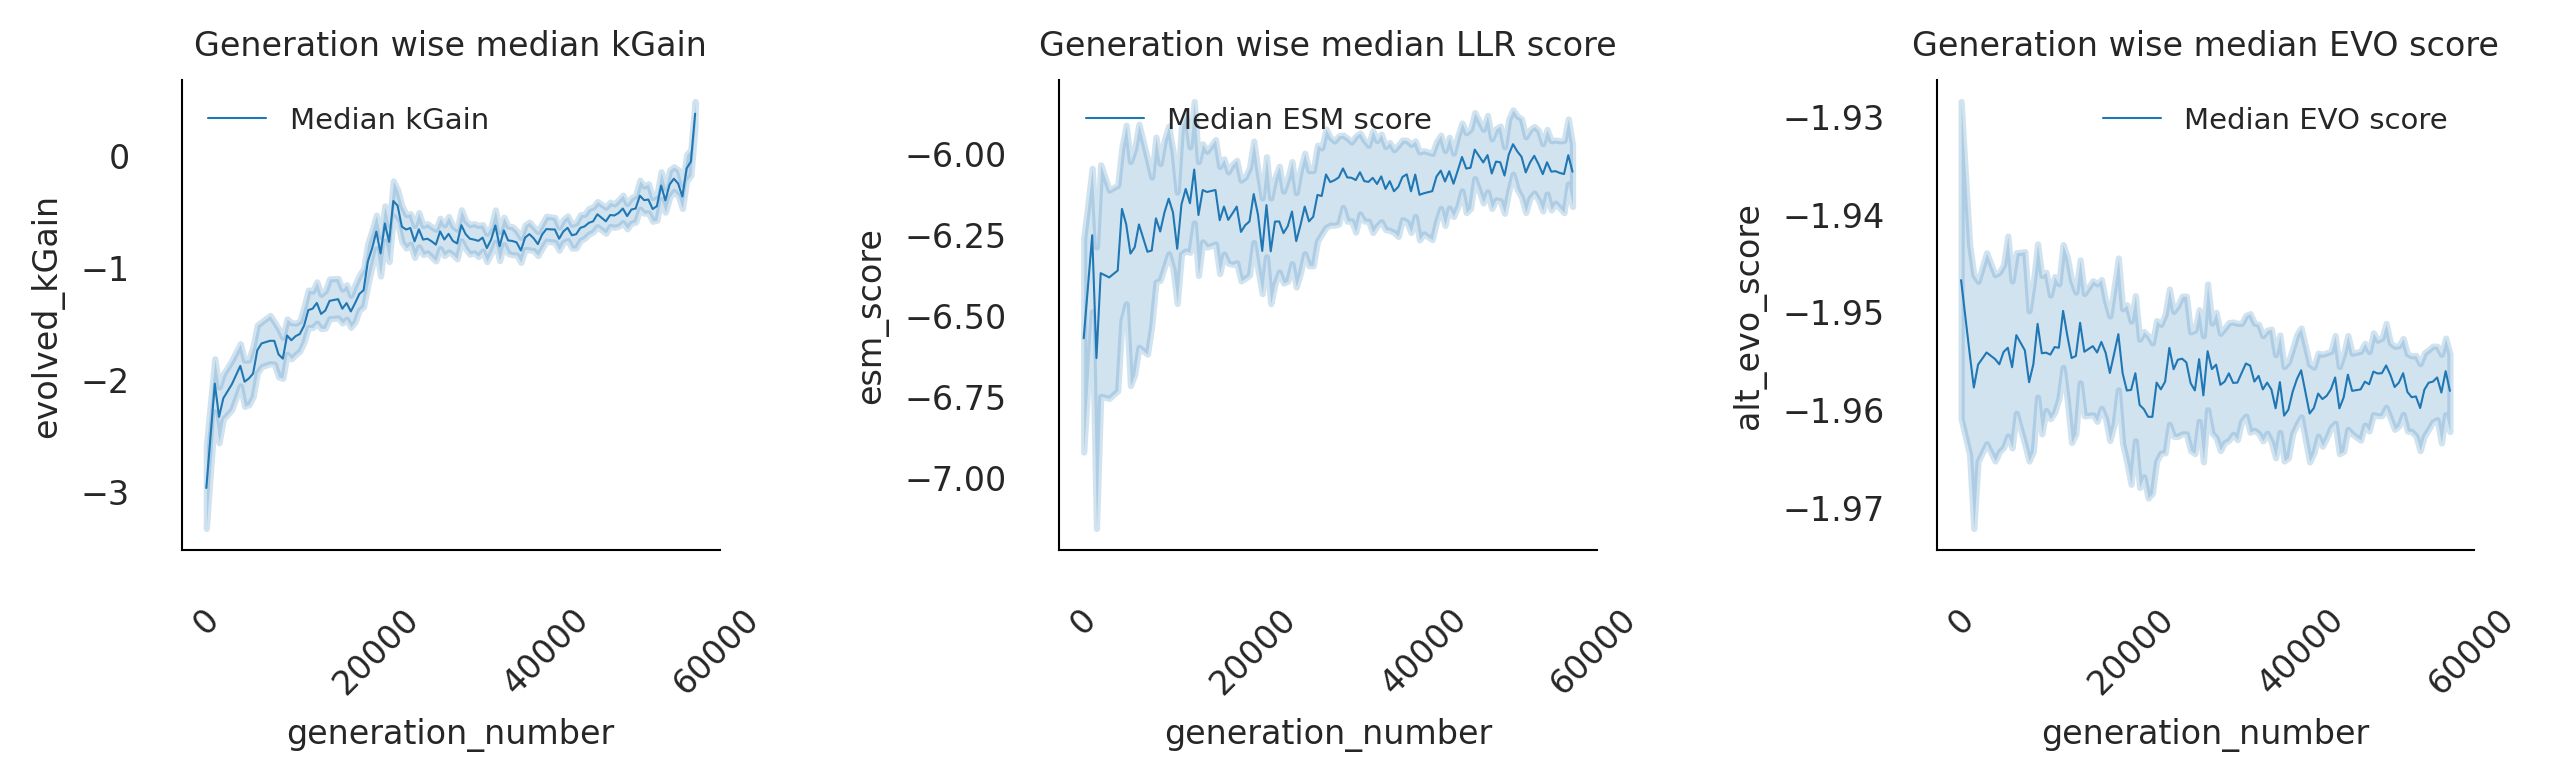

In [153]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi = 300)
ax[0] = sns.lineplot(mutation_with_essentiality_df_with_allele_frequency, x = "generation_number",  y = 'evolved_kGain', ax=ax[0], lw = 0.5, label = "Median kGain", estimator='median')

ax[1] = sns.lineplot(all_mutation_with_esm_1b_score, x = "generation_number",  y = "esm_score", ax=ax[1], lw = 0.5, label = "Median ESM score", estimator='median')
ax[2] = sns.lineplot(all_mutation_with_evo_score, x = "generation_number",  y = "alt_evo_score", ax=ax[2], lw = 0.5, label = "Median EVO score", estimator='median')
ax[0]= utility.custom_figure_axis(ax[0], fontsize=8, show_ticks = True, rotation=45)
ax[1]= utility.custom_figure_axis(ax[1], fontsize=8, show_ticks = True, rotation=45)
ax[2]= utility.custom_figure_axis(ax[2], fontsize=8, show_ticks = True, rotation=45)
ax[0].legend(fontsize = 7, frameon=False)
ax[1].legend(fontsize = 7, frameon=False)
ax[2].legend(fontsize = 7, frameon=False)
ax[0].set_title("Generation wise median kGain", fontsize = 8)
ax[1].set_title("Generation wise median LLR score", fontsize = 8)
ax[2].set_title("Generation wise median EVO score", fontsize = 8)

plt.tight_layout()


##### Fig. 2d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


P-value = 2.40e-02 and effect size = 8.00e-02


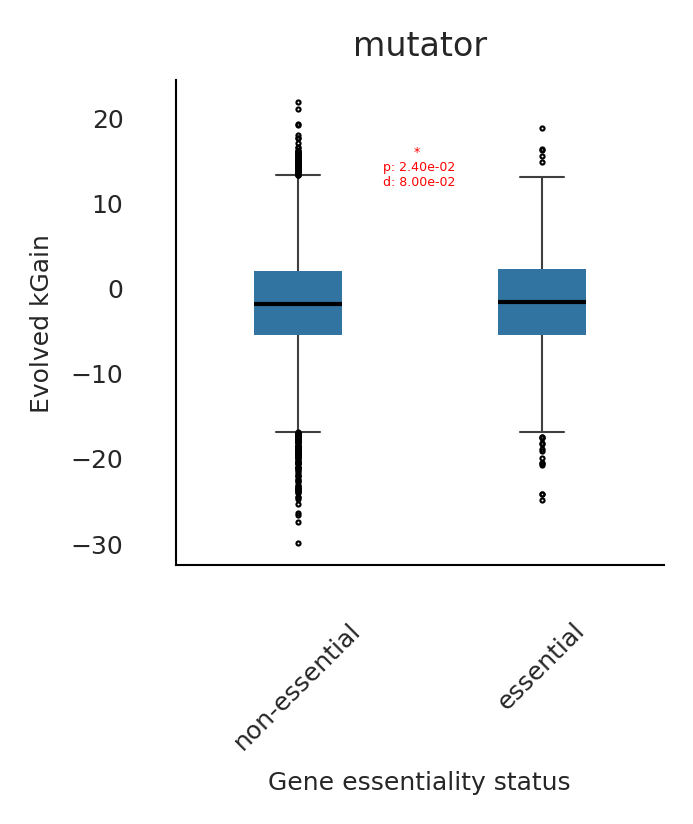

In [154]:

x_columns = 'essentiality_status'
y_columns = "evolved_kGain"
group1_name = 'essential'
group2_name = 'non-essential'
type = "mutator"
data = kgain_mutations_annotated[kgain_mutations_annotated["mutator_type"]==type]

fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (2.1, 2.1), sharex=True)
ax.set_title(type, fontsize = 8)

ax= sns.boxplot(data=data,
                y = y_columns, x = x_columns, boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax= utility.custom_figure_axis(ax, fontsize=6, show_ticks = True, rotation=45)
ax.set_ylabel("Evolved kGain")
ax.set_xlabel("Gene essentiality status")
ax.legend(ncol=2, fontsize = 4, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = data, x_columns = x_columns, y_columns = y_columns, group1_name = group1_name, group2_name = group2_name, y_pos = 12,  fontsize=3)

##### Fig. 2e

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


P-value = 5.14e-05 and effect size = 3.05e-01


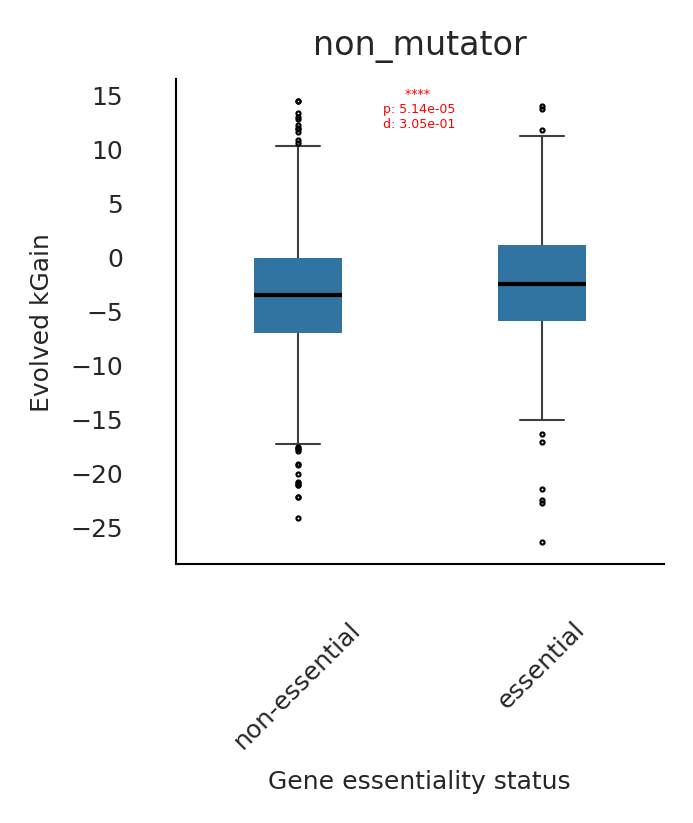

In [155]:

x_columns = 'essentiality_status'
y_columns = "evolved_kGain"
group1_name = 'essential'
group2_name = 'non-essential'
type = "non_mutator"
data = kgain_mutations_annotated[kgain_mutations_annotated["mutator_type"]==type]

fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (2.1, 2.1), sharex=True)
ax.set_title(type, fontsize = 8)

ax= sns.boxplot(data=data,
                y = y_columns, x = x_columns, boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax= utility.custom_figure_axis(ax, fontsize=6, show_ticks = True, rotation=45)
ax.set_ylabel("Evolved kGain")
ax.set_xlabel("Gene essentiality status")
ax.legend(ncol=2, fontsize = 4, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = data, x_columns = x_columns, y_columns = y_columns, group1_name = group1_name, group2_name = group2_name, y_pos = 12,  fontsize=3)

##### Fig. 3(f-g)


 Bootstrapping Mean AG Scores (Essential vs Non-Essential) in: mutator
  Sampling 3051 from each (min group size=3391)
  Essential mean evolved kGain: -1.6620 (95% CI: -1.7245 - -1.6001)
  Non-essential mean evolved kGain: -1.8597 (95% CI: -2.0449 - -1.6782)


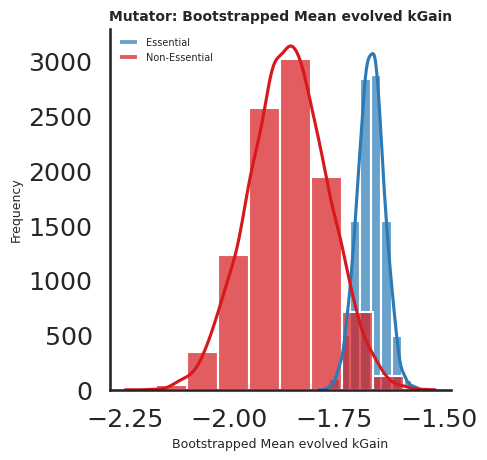


 Bootstrapping Mean AG Scores (Essential vs Non-Essential) in: non_mutator
  Sampling 346 from each (min group size=385)
  Essential mean evolved kGain: -2.3270 (95% CI: -2.5268 - -2.1169)
  Non-essential mean evolved kGain: -3.4883 (95% CI: -4.0028 - -2.9831)


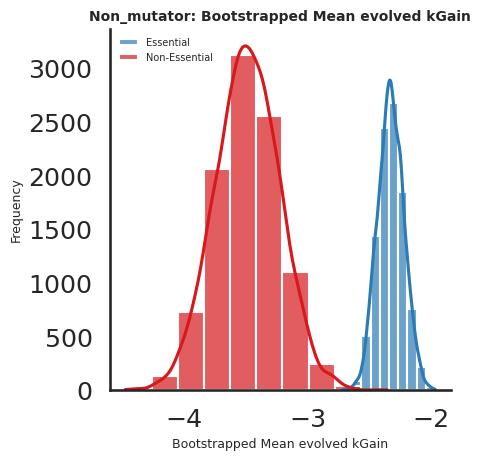

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42) 
def bootstrap_means_essential_vs_nonessential(df, mutator_type, n_iter=10000):
    print(f"\n Bootstrapping Mean AG Scores (Essential vs Non-Essential) in: {mutator_type}")

    # Subset the group
    sub = df[df['mutator_type'] == mutator_type].copy()
    # sub['type'] = sub['type'].str.strip()
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    essential = sub[sub['essentiality_status'] == 'essential']['evolved_kGain'].values
    non_essential = sub[sub['essentiality_status'] == 'non-essential']['evolved_kGain'].values

    # Determine min group size
    min_len = min(len(essential), len(non_essential))
    n_sample = int(0.9 * min_len)

    print(f"  Sampling {n_sample} from each (min group size={min_len})")

    # Bootstrapped means
    boot_means_essential = np.array([
        np.mean(np.random.choice(essential, n_sample, replace=False))
        for _ in range(n_iter)
    ])
    boot_means_nonessential = np.array([
        np.mean(np.random.choice(non_essential, n_sample, replace=False))
        for _ in range(n_iter)
    ])

    # Statistics
    essential_mean = np.mean(boot_means_essential)
    nonessential_mean = np.mean(boot_means_nonessential)
    essential_ci = np.percentile(boot_means_essential, [2.5, 97.5])
    nonessential_ci = np.percentile(boot_means_nonessential, [2.5, 97.5])

    print(f"  Essential mean evolved kGain: {essential_mean:.4f} (95% CI: {essential_ci[0]:.4f} - {essential_ci[1]:.4f})")
    print(f"  Non-essential mean evolved kGain: {nonessential_mean:.4f} (95% CI: {nonessential_ci[0]:.4f} - {nonessential_ci[1]:.4f})")

    # --- Plot ---
    plt.figure(figsize=(5, 5))
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("white")

    sns.histplot(boot_means_essential, bins=10, kde=True, color='#2C7BB6', label='Essential', alpha=0.7)
    sns.histplot(boot_means_nonessential, bins=10, kde=True, color='#D7191C', label='Non-Essential', alpha=0.7)

    # sns.kdeplot(boot_means_essential, color='#2C7BB6', label='Essential', alpha=0.7)
    # sns.kdeplot(boot_means_nonessential, color='#D7191C', label='Non-Essential', alpha=0.7)

    plt.title(f"{mutator_type.capitalize()}: Bootstrapped Mean evolved kGain", fontsize=10, weight='bold')
    plt.xlabel("Bootstrapped Mean evolved kGain", fontsize=9)
    plt.ylabel("Frequency", fontsize=9)
    plt.legend(fontsize = 7, ncol = 1, loc='upper left', frameon=False)
    plt.grid(False)
    sns.despine()
    plt.tight_layout()

    # Save to local PDF
    filename = f"bootstrap_means_essential_vs_non_essential_{mutator_type.replace(' ', '_')}.pdf"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
bootstrap_means_essential_vs_nonessential(kgain_mutations_annotated, 'mutator')
bootstrap_means_essential_vs_nonessential(kgain_mutations_annotated, 'non_mutator')

##### Fig. 3 (h-i)

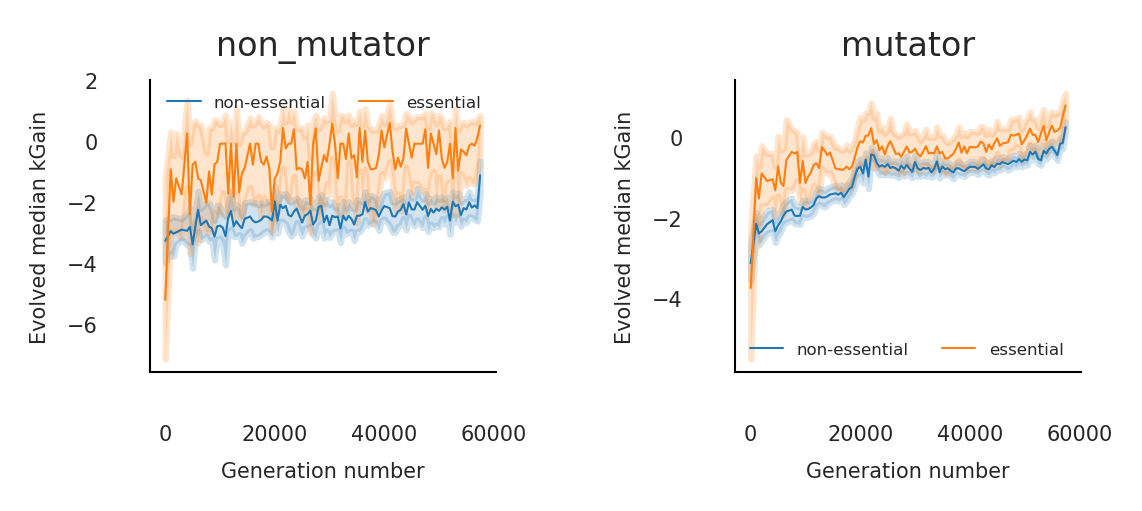

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(4.2, 2.1), dpi=300)
# from matplotlib.ticker import AutoLocator
# coding_types = ["coding", "noncoding"]
mutator_types = ["non_mutator", "mutator"]

# for i, coding_type_tmp in enumerate(coding_types):
for j, mutator_type_tmp in enumerate(mutator_types):
    subset = mutation_with_essentiality_df[
        # (mutation_with_essentiality_df["coding_type"] == coding_type_tmp) & 
        (mutation_with_essentiality_df["mutator_type"] == mutator_type_tmp)
    ]
    ax[j] = sns.lineplot(subset, x="generation_number", y="evolved_kGain",
                    hue="essentiality_status", ax=ax[j], lw=0.5, estimator='median')
    ax[j].set_xlabel("Generation number")
    ax[j].set_ylabel("Evolved median kGain")
    ax[j].set_title(f"{mutator_type_tmp}", fontsize=8)
    ax[j] = utility.custom_figure_axis(ax[j], fontsize=5, rotation=0)
    ax[j] .legend(ncol = 2, fontsize=4, frameon=False)
    # ax[j].xaxis.set_major_locator(AutoLocator())
    # ax[j].yaxis.set_major_locator(AutoLocator())
    ax[j].tick_params(axis='both', which='both', direction='out')
plt.tight_layout()
# plt.savefig("Evolved median kGain vs generation with mutator type and essentiality as hue.pdf", dpi = 300)

##### Fig. 3j

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


P-value = 1.04e-242 and effect size = 7.94e-01


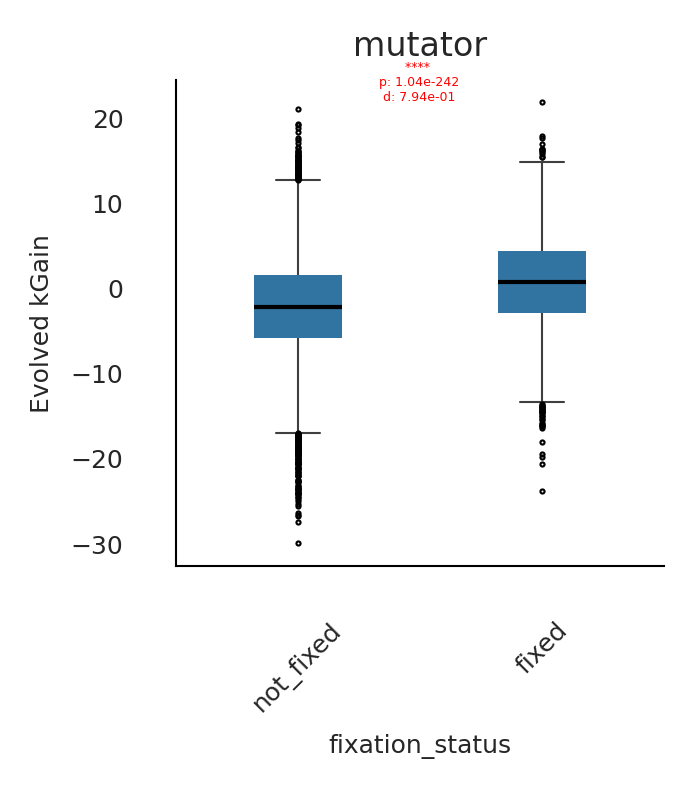

In [158]:
x_columns = 'fixation_status'
y_columns = "evolved_kGain"
group1_name = 'fixed'
group2_name = 'not_fixed'
type = "mutator"
data = annotated_mutations_df_unique_with_fixation_status[annotated_mutations_df_unique_with_fixation_status["mutator_type"]==type]

fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (2.1, 2.1), sharex=True)
ax.set_title(type, fontsize = 8)

ax= sns.boxplot(data=data,
                y = y_columns, x = x_columns, boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax= utility.custom_figure_axis(ax, fontsize=6, show_ticks = True, rotation=45)
ax.set_ylabel("Evolved kGain")
ax.legend(ncol=2, fontsize = 4, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = data, x_columns = x_columns, y_columns = y_columns, group1_name = group1_name, group2_name = group2_name, y_pos = 22,  fontsize=3)

##### Fig. 3k

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


P-value = 7.95e-14 and effect size = 7.69e-01


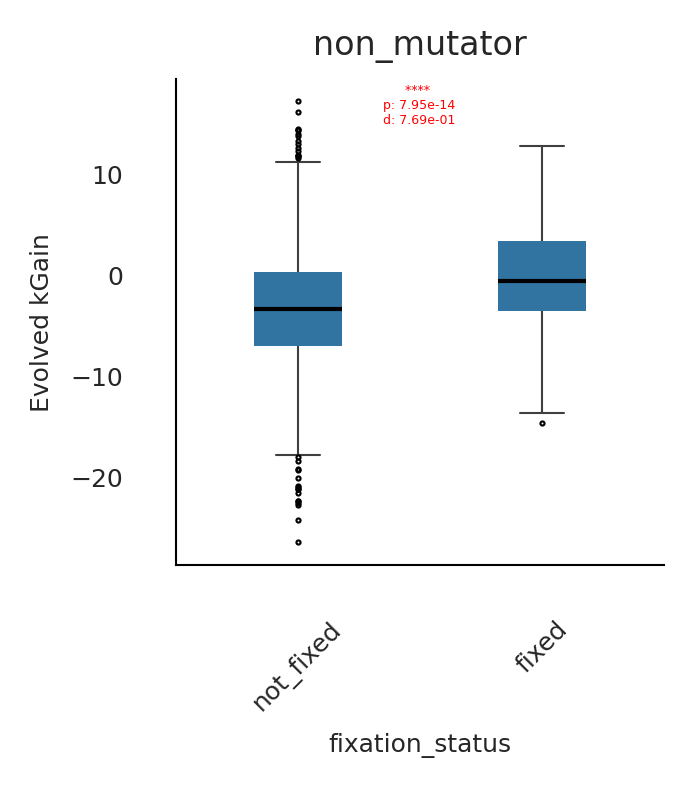

In [159]:
x_columns = 'fixation_status'
y_columns = "evolved_kGain"
group1_name = 'fixed'
group2_name = 'not_fixed'
type = "non_mutator"
data = annotated_mutations_df_unique_with_fixation_status[annotated_mutations_df_unique_with_fixation_status["mutator_type"]==type]

fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (2.1, 2.1), sharex=True)
ax.set_title(type, fontsize = 8)

ax= sns.boxplot(data=data,
                y = y_columns, x = x_columns, boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax= utility.custom_figure_axis(ax, fontsize=6, show_ticks = True, rotation=45)
ax.set_ylabel("Evolved kGain")
ax.legend(ncol=2, fontsize = 4, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = data, x_columns = x_columns, y_columns = y_columns, group1_name = group1_name, group2_name = group2_name, y_pos = 15,  fontsize=3)

In [173]:
parallel_genes_df = pd.read_excel("../../../data/NIHMS908078-supplement-Supplementary_Table_3.xlsx")
parallel_genes_df["Gene_parallel_type"] = "parallel"
mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene = pd.merge(mutation_with_essentiality_df_with_allele_frequency, parallel_genes_df[["Gene", "Gene_parallel_type"]], how="left")
mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["Gene_parallel_type"] = mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['Gene_parallel_type'].fillna("non_parallel")
mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene = strip_whitespace_from_string_columns(mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene)


In [215]:
# bin_size = 5000
# mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin'] = (mutation_with_essentiality_df_with_allele_frequency['generation_number'] // bin_size) * bin_size

# mutator_types = ["non_mutator", "mutator"]
# gene_parallel_type = ["non_parallel", "parallel"]

# fig, ax = plt.subplots(1,1,  figsize=(4.4, 2.2), dpi = 300)

# for i, gene_type_tmp in enumerate(gene_parallel_type):
#     for j, mutator_type_tmp in enumerate(mutator_types):
#         subset = mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene[
#             (mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["Gene_parallel_type"] == gene_type_tmp) & 
#             (mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["mutator_type"] == mutator_type_tmp)
#         ]

#         if ((gene_type_tmp=="non_parallel") & (mutator_type_tmp=="mutator")):
#             col = "blue"

#         if ((gene_type_tmp=="parallel") & (mutator_type_tmp=="mutator")):
#             col = "orange"

#         if ((gene_type_tmp=="non_parallel") & (mutator_type_tmp=="non_mutator")):
#             col = "green"
#         if ((gene_type_tmp=="parallel") & (mutator_type_tmp=="non_mutator")):
#             col = "red"
#         ax = sns.lineplot(subset, x="generation_bin", y='allele_freq', ax=ax, lw=0.5, estimator='median', label = f"{gene_type_tmp}, {mutator_type_tmp}", color=col, linestyle='-' if gene_type_tmp=='parallel' else '--')
#         # ax = sns.scatterplot(data=subset, x="generation_bin", y="allele_freq")
#         ax.set_xlabel("Generation Bin")
#         ax.set_ylabel("Median allele frequency")
#         group_median = subset.groupby("generation_bin")['allele_freq'].median()
#         ax.scatter(
#             group_median.index, group_median.values,
#             s=8,  # marker size
#             alpha=0.85,
#             edgecolors="none",
#             c=col
#             # You may set color, marker, etc. for each group here if needed
#         )

#         # ax.set_title(f"{coding_type_tmp}, {mutator_type_tmp}", fontsize=8)
        
#         ax .legend(ncol = 4, fontsize=4, frameon=False)
# xticks = np.arange(0, 60000+1, 10000)
# ax.set_xticks(xticks)
# ax.set_xticklabels([f"{int(x/1000)}k" if x != 0 else "0" for x in xticks], fontsize=6)
# ax.set_ylim(-0.1, 1.2)

# from scipy.stats import mannwhitneyu

# # Store x positions and p-values for annotation
# pvalues_mutator = []
# pvalues_nonmutator = []
# x_positions = []

# for bin_val in sorted(mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["generation_bin"].unique()):
#     # Mutator comparison
#     sub_mut = mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene[
#         (mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["generation_bin"] == bin_val) & 
#         (mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["mutator_type"] == "mutator")
#     ]
#     vals_parallel = sub_mut[sub_mut["Gene_parallel_type"] == "parallel"]["allele_freq"]
#     vals_nonparallel = sub_mut[sub_mut["Gene_parallel_type"] == "non_parallel"]["allele_freq"]
#     if len(vals_parallel) > 0 and len(vals_nonparallel) > 0:
#         stat, pval = mannwhitneyu(vals_parallel, vals_nonparallel, alternative='greater')
#         pvalues_mutator.append(pval)
#     else:
#         pvalues_mutator.append(np.nan)

#     # Non-mutator comparison
#     sub_nonmut = mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene[
#         (mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["generation_bin"] == bin_val) & 
#         (mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["mutator_type"] == "non_mutator")
#     ]
#     vals_parallel_nm = sub_nonmut[sub_nonmut["Gene_parallel_type"] == "parallel"]["allele_freq"]
#     vals_nonparallel_nm = sub_nonmut[sub_nonmut["Gene_parallel_type"] == "non_parallel"]["allele_freq"]
#     if len(vals_parallel_nm) > 0 and len(vals_nonparallel_nm) > 0:
#         stat_nm, pval_nm = mannwhitneyu(vals_parallel_nm, vals_nonparallel_nm, alternative='greater')
#         pvalues_nonmutator.append(pval_nm)
#     else:
#         pvalues_nonmutator.append(np.nan)

#     x_positions.append(bin_val)

# # Annotate p-values on the plot
# for x, p_m, p_nm in zip(x_positions, pvalues_mutator, pvalues_nonmutator):
#     # Example: Annotate asterisks for significance level for mutator (top) and non-mutator (bottom)
#     # You can adjust y positions as needed
#     if not np.isnan(p_m):
#         y = 1  # Slightly above the top of plot for mutator
#         if p_m < 0.0001:
#             txt = '****'
#         elif p_m < 0.001:
#             txt = '***'
#         elif p_m < 0.01:
#             txt = '**'
#         elif p_m < 0.05:
#             txt = '*'
#         else:
#             txt = ''
#         ax.text(x, y, txt, ha='center', va='bottom', color='orange', fontsize=4, clip_on=False)
#     if not np.isnan(p_nm):
#         y = -0.05  # Slightly below plot for non-mutator
#         if p_nm < 0.0001:
#             txt = '****'
#         elif p_nm < 0.001:
#             txt = '***'
#         elif p_nm < 0.01:
#             txt = '**'
#         elif p_nm < 0.05:
#             txt = '*'
#         else:
#             txt = ''
#         ax.text(x, y, txt, ha='center', va='top', color='red', fontsize=4, clip_on=False)

# plt.tight_layout()

# ax = utility.custom_figure_axis(ax, fontsize=5, rotation=0)
# plt.tight_layout()
# # plt.savefig("Median allele frequency vs 5k binned generation with parallel genes.pdf", dpi=300 )
# # plt.show()

In [185]:
full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene = mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene[mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene["Gene"].isin(parallel_genes_df["Gene"])]


##### Fig. 3l

/tmp/ipykernel_561253/317779659.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['generation_bin_mid', 'mutator_type'])


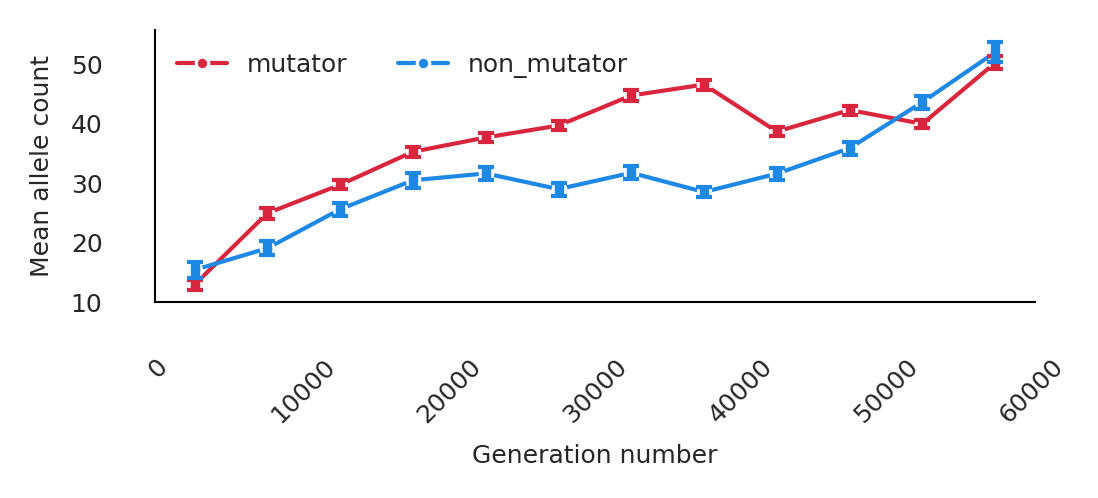

In [210]:
bin_edges = range(0, int(full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_number'].max()) + 5000, 5000)
full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin'] = pd.cut(full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_number'], bins=bin_edges, right=False)
full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin_mid'] = full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin'].apply(lambda x: x.mid)

# --- Step 2: Group with SEM for error bars ---
agg_df = (
    full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene
    .groupby(['generation_bin_mid', 'mutator_type'])
    .agg(
        allele_mean=( 'allele_count', 'mean'),
        allele_sem=( 'allele_count', 'sem'),
    )
    .reset_index()
)

# --- Step 3: Plot AG over generations ---
palette = {'mutator': '#D7263D', 'non_mutator': '#1E88E5'}  # Bright red & blue
sns.set_style("white")
sns.set_context("talk")

# plt.figure(figsize=(10, 6))

fig, ax = plt.subplots(1, 1, figsize = (4, 2), dpi = 300)
ax = sns.lineplot(
    data=agg_df,
    x='generation_bin_mid',
    y='allele_mean',
    hue='mutator_type',
    marker='o',
    linewidth=1,
    ms = 3,
    palette=palette,
    ax = ax
)

# Add error bars
for mutator_type in agg_df['mutator_type'].unique():
    sub = agg_df[agg_df['mutator_type'] == mutator_type]
    ax.errorbar(sub['generation_bin_mid'], sub['allele_mean'], yerr=sub['allele_sem'], fmt='none', capsize=2, color=palette[mutator_type])

ax = utility.custom_figure_axis(ax, fontsize = 6, rotation=45)
ax.legend(ncol = 2, fontsize = 6, frameon =False)
ax.set_ylabel("Mean allele count")
ax.set_xlabel("Generation number")

plt.tight_layout()

##### Fig. 3m

/tmp/ipykernel_561253/329568943.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['generation_bin_mid', 'mutator_type'])


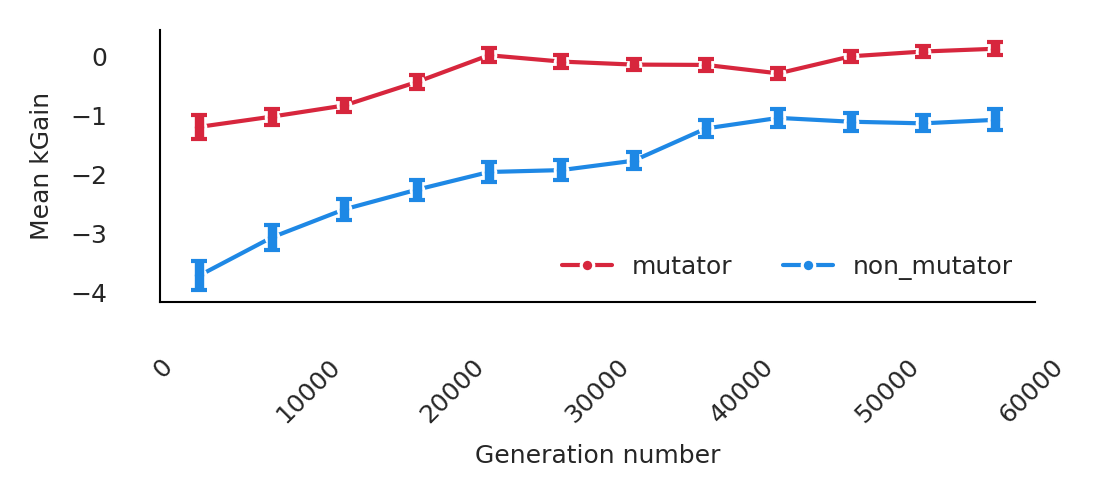

In [214]:
bin_edges = range(0, int(full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_number'].max()) + 5000, 5000)
full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin'] = pd.cut(full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_number'], bins=bin_edges, right=False)
full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin_mid'] = full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene['generation_bin'].apply(lambda x: x.mid)

# --- Step 2: Group with SEM for error bars ---
agg_df = (
    full_mutation_with_essentiality_df_with_allele_frequency_with_parallel_gene
    .groupby(['generation_bin_mid', 'mutator_type'])
    .agg(
        kGain_mean=('evolved_kGain', 'mean'),
        kGain_sem=('evolved_kGain', 'sem'),
    )
    .reset_index()
)

# --- Step 3: Plot AG over generations ---
palette = {'mutator': '#D7263D', 'non_mutator': '#1E88E5'}  # Bright red & blue
sns.set_style("white")
sns.set_context("talk")

# plt.figure(figsize=(10, 6))

fig, ax = plt.subplots(1, 1, figsize = (4, 2), dpi = 300)
ax = sns.lineplot(
    data=agg_df,
    x='generation_bin_mid',
    y='kGain_mean',
    hue='mutator_type',
    marker='o',
    linewidth=1,
    ms = 3,
    palette=palette,
    ax = ax
)

# Add error bars
for mutator_type in agg_df['mutator_type'].unique():
    sub = agg_df[agg_df['mutator_type'] == mutator_type]
    ax.errorbar(sub['generation_bin_mid'], sub['kGain_mean'], yerr=sub['kGain_sem'], fmt='none', capsize=2, color=palette[mutator_type])

ax = utility.custom_figure_axis(ax, fontsize = 6, rotation=45)
ax.legend(ncol = 2, fontsize = 6, frameon =False)
ax.set_ylabel("Mean kGain")
ax.set_xlabel("Generation number")
plt.tight_layout()